<a href="https://colab.research.google.com/github/ds4ph-bme/project-5-SeanSDarcy2001/blob/main/proj5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.687421
         Iterations 4


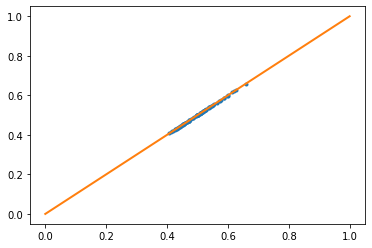

In [2]:
import pandas as pd
import numpy as np
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt

dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")

 
m = np.median(dat.GOLD_Lesions)
dat = dat.assign(y = (dat.GOLD_Lesions > m) * 1 )
dat = dat.assign(x = (dat.T2 - np.mean(dat.T2)) / np.std(dat.T2))
dat.head()
fit = smf.logit('y ~ x', data = dat).fit()
fit.summary()

yhat = 1 / (1 + np.exp(-fit.fittedvalues))

n = dat.shape[0]

xtraining = torch.from_numpy(dat['x'].values)
ytraining = torch.from_numpy(dat['y'].values)

xtraining = xtraining.float()
ytraining = ytraining.float()

xtraining = xtraining.unsqueeze(1)
ytraining = ytraining.unsqueeze(1)

class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(1, 1, bias = True)
  def forward(self, x):
    y_pred = torch.sigmoid(self.linear(x))
    return y_pred

model = LogisticRegression()

lossFunc = torch.nn.BCELoss(reduction ='sum')

opt = torch.optim.SGD(model.parameters(), lr=1e-4)

for i in range(10000) :
  
  #fwd prop
  y_pred = model(xtraining)

  loss = lossFunc(y_pred, ytraining)

  opt.zero_grad()

  loss.backward()

  opt.step()

ytest = model(xtraining)
ytest = ytest.detach().numpy().reshape(-1)
plt.plot(yhat, ytest,  ".")
plt.plot([0, 1], [0, 1], linewidth=2)






In [27]:
dat = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv')


def oneHotEncode(data):
  cat = np.unique(data)
  one_hot_df = pd.DataFrame(np.zeros((53940,len(cat))))
  one_hot_df.columns = cat

  for c in cat:
    for row in range(len(data)) :  
      if (data[row] == c):
        one_hot_df.loc[row, c] = 1 
  
  return one_hot_df


cut_column = dat[['cut']].to_numpy()
one_hot_cut = oneHotEncode(cut_column)

color_column = dat[['color']].to_numpy()
one_hot_color = oneHotEncode(color_column)

clarity_column = dat[['clarity']].to_numpy()
one_hot_clarity = oneHotEncode(clarity_column)


   Fair  Good  Ideal  Premium  Very Good
0   0.0   0.0    1.0      0.0        0.0
1   0.0   0.0    0.0      1.0        0.0
2   0.0   1.0    0.0      0.0        0.0
3   0.0   0.0    0.0      1.0        0.0
4   0.0   1.0    0.0      0.0        0.0
     D    E    F    G    H    I    J
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0
    I1   IF  SI1  SI2  VS1  VS2  VVS1  VVS2
0  0.0  0.0  0.0  1.0  0.0  0.0   0.0   0.0
1  0.0  0.0  1.0  0.0  0.0  0.0   0.0   0.0
2  0.0  0.0  0.0  0.0  1.0  0.0   0.0   0.0
3  0.0  0.0  0.0  0.0  0.0  1.0   0.0   0.0
4  0.0  0.0  0.0  1.0  0.0  0.0   0.0   0.0


In [33]:
df = dat[['carat', 'price']]
df = pd.concat([df, one_hot_cut, one_hot_color, one_hot_clarity], axis=1)

p = (df.price - np.mean(df.price)) / np.std(df.price)
df.price = p

p = (df.carat - np.mean(df.carat)) / np.std(df.carat)
df.carat = p
df.head()

,carat,price,Fair,Good,Ideal,Premium,Very Good,D,E,F,G,H,I,J,I1,IF,SI1,SI2,VS1,VS2,VVS1,VVS2
0,-1.198168,-0.904095,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.240361,-0.904095,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.198168,-0.903844,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.071587,-0.902090,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.029394,-0.901839,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


RMSE: 0.14704676


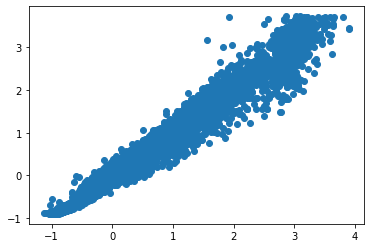

In [59]:
trainFraction = .75
sample = np.random.uniform(size = 53940) < trainFraction
trainingDat = df[sample]
testingDat = df[~sample]

x = df.drop(['price'], axis=1)
y = df.price

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

xtraining = torch.from_numpy(pd.DataFrame.to_numpy(xtraining)).float()
xtesting = torch.from_numpy(pd.DataFrame.to_numpy(xtesting)).float()
ytraining = torch.from_numpy(pd.DataFrame.to_numpy(ytraining)).float().unsqueeze(1)
ytesting = torch.from_numpy(pd.DataFrame.to_numpy(ytesting)).float().unsqueeze(1)

#print((xtesting))
#print((ytesting))

H1 = 3
H2 = 5
D_in = xtraining.size()[1]
D_out = 1

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out, bias=True),
)

lossFunc = torch.nn.MSELoss(reduction='sum')
opti = torch.optim.Adam(model.parameters())

learning_rate = 1e-4
for t in range(50000):
    y_pred = model(xtraining)
    loss = lossFunc(y_pred, ytraining)
    # if t % 100 == 99:
    #     print(t, loss.item())
    opti.zero_grad()
    loss.backward()
    opti.step()

ytesting_pred = model(xtesting)
a = ytesting_pred.detach().numpy()
b = ytesting.detach().numpy()

plt.scatter(a[:,0], ytesting[:,0])



print("RMSE:", np.sqrt(((a - b) ** 2).mean()))






In [14]:
print(xtraining.size()[1])

23
